# EOBS seasonal means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

dask.config.set(scheduler="single-threaded")

time_range_default = slice("1981", "2000")
xarray_open_kwargs = {"use_cftime": True, "decode_coords": "all", "chunks": None}

In [3]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44901 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44901/status,
Dashboard: http://127.0.0.1:44901/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43791,Workers: 16
Dashboard: http://127.0.0.1:44901/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:42593,Total threads: 1
Dashboard: http://127.0.0.1:39169/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:38081,


In [4]:
vertices = {'CMIP6': ("vertices_lon", "vertices_lat"),
            'CMIP5': ("lon_vertices", "lat_vertices")}

def add_bounds(ds, mip_era = 'CMIP6'):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=vertices[mip_era])
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
            ),
        )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        source = [ds.attrs[attr] for attr in ['source_id', 'model_id', 'source'] if attr in ds.attrs]
        warn(f"sftlf not found in dataset: {source[0]}")
    return ds


def open_datasets(variables, frequency="mon", driving_source_id="ERA5", 
                  mask=True, add_missing_bounds=False, **kargs):
    catalog = get_source_collection(variables, frequency, driving_source_id,
                                    add_fx=["areacella", "sftlf"])
    dsets = open_and_sort(catalog, merge=merge, concat=False, 
                          time_range = kargs.get("time_range", None))
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            if driving_source_id == 'ERA5':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP6')
            elif driving_source_id == 'ECMWF-ERAINT':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP5')                
    return dsets

def create_cordex_grid(domain_id, mip_era = 'CMIP6'):
    grid = cx.domain(domain_id, bounds=True, mip_era=mip_era)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            #continue
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except Exception as e:
            prin("problmes with grid_mapping definition")
            continue
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets
    
def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [5]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [6]:
mip_era = 'CMIP5'
variable = 'tas'
frequency = 'mon'
domain = "EUR-11"
regridding = "bilinear"
driving_source_id = 'ECMWF-ERAINT'# ECMWF-ERAINT/ERA5
models = ["ICON-CLM-202407-1-1", "REMO2020", "HCLIM43-ALADIN", "RACMO23E", "CNRM-ALADIN64E1"]
#models = ["CCLM4-8-17", "REMO2015", "ALADIN63", "RACMO22E"]
#levels = np.arange(-100, 110, 10)#
#levels = np.arange(-8, 9, 1)
cmap="BrBG"
#cmap = "RdBu_r"
period = slice("1980", "2000")

In [7]:
default_attrs = [
        "project_id",
        "domain_id",
        "institution_id",
        "driving_source_id",
        "driving_experiment_id",
        "driving_variant_label",
        "source_id",
        "version_realization",
        'frequency',
        'variable_id',
        "version"
]

In [8]:
# Define how to merge the files in xarray
if driving_source_id == 'ERA5':
    merge = ["variable_id", "frequency"]
elif driving_source_id == 'ECMWF-ERAINT':
    merge = ["variable_id", "frequency", "driving_variant_label", "version"]
default_attrs = [d for d in default_attrs if not d in merge]

In [9]:
dsets = open_datasets([variable], frequency=frequency, driving_source_id = driving_source_id,
                     mask=True, add_missing_bounds=False, 
                      **{'merge': merge, 'time_range': period})

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_o

Found 22 datasets
merging: CORDEX.EUR-11.CLMcom.ECMWF-ERAINT.evaluation.CCLM4-8-17.v1
merging: CORDEX.EUR-11.CLMcom-ETH.ECMWF-ERAINT.evaluation.COSMO-crCLIM-v1-1.v1
merging: CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.ALADIN53.v1
merging: CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.ALADIN63.v1
merging: CORDEX.EUR-11.DHMZ.ECMWF-ERAINT.evaluation.RegCM4-2.v1
merging: CORDEX.EUR-11.GERICS.ECMWF-ERAINT.evaluation.REMO2015.v1
merging: CORDEX.EUR-11.KNMI.ECMWF-ERAINT.evaluation.RACMO22E.v1
merging: CORDEX.EUR-11.MOHC.ECMWF-ERAINT.evaluation.HadREM3-GA7-05.v1
merging: CORDEX.EUR-11.MPI-CSC.ECMWF-ERAINT.evaluation.REMO2009.v1
merging: CORDEX.EUR-11.RMIB-UGent.ECMWF-ERAINT.evaluation.ALARO-0.v1
merging: CORDEX.EUR-11.SMHI.ECMWF-ERAINT.evaluation.RCA4.v1


In [10]:
rotated_grid = create_cordex_grid(domain, mip_era=mip_era)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.ALADIN53.v1 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.ALADIN63.v1 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.DHMZ.ECMWF-ERAINT.evaluation.RegCM4-2.v1 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_412x424.nc 
Reuse pre-computed weights? False 
Inpu

In [11]:
eobs = obs.eobs(variable, add_mask=False).sel(time=period)
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)

In [12]:
#eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
eobs_on_rotated = regridder(eobs)

In [13]:
%%time
eobs_seasmean = seasonal_mean(eobs_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.51 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3.44 s, sys: 829 ms, total: 4.27 s
Wall time: 24.8 s


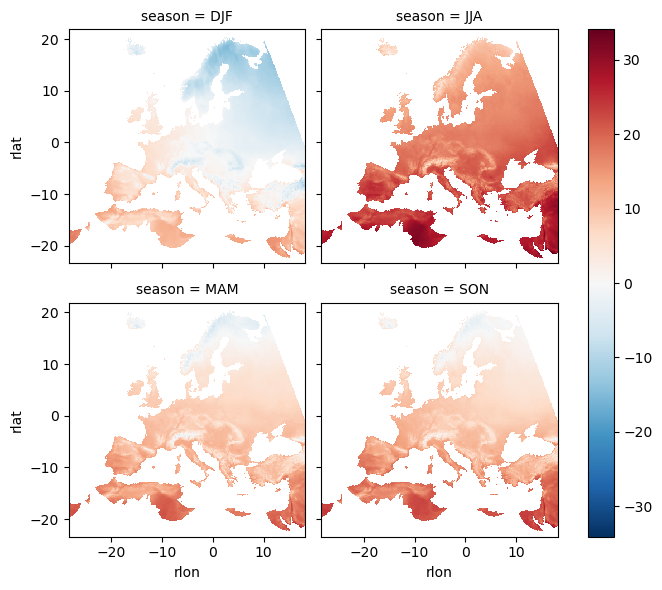

In [14]:
eobs_seasmean.plot(col="season", col_wrap=2)

In [15]:
#diffs = {
#    dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
#    - (eobs_seasmean + 273.15)
#    for dset_id, ds in dsets.items()
#}

if variable == 'tas':
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (eobs_seasmean + 273.15)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
elif variable == 'pr':
    diffs = {
        dset_id: 100*(seasonal_mean(ds[[variable]].sel(time=period)).compute()*86400 - (eobs_seasmean))/(eobs_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }

        
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id"], default_attrs = default_attrs), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [16]:
import regionmask
from dask.diagnostics import ProgressBar
from evaltools.eval import regional_means

In [17]:
# prudence
regions = regionmask.defined_regions.prudence

In [21]:
dset_id_regions = regional_means(seasonal_bias, regions)
#dset_id_regions.to_netcdf(f'{mip_era}-CORDEX_{variable}_region_means_{period.start}-{period.stop}.nc')
#dset_id_regions = create_regional_means(seasonal_bias, regions)

#### Load results for both CMIP5 and CMIP6 simulations

In [20]:
dset_id_regions_CMIP6 = xr.open_dataset('CMIP6-CORDEX_tas_region_means_1980-2000.nc')
dset_id_regions_CMIP5 = xr.open_dataset('CMIP5-CORDEX_tas_region_means_1980-2000.nc')

In [85]:
import sys
import warnings, math
from matplotlib import cm
from matplotlib.colors import ListedColormap

/tmp/ipykernel_3536364/3024891460.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_CMIP6 = cm.get_cmap('tab20', len(unique_dsets_CMIP6))
/tmp/ipykernel_3536364/3024891460.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_CMIP5 = cm.get_cmap('tab20', len(unique_dsets_CMIP5))
/tmp/ipykernel_3536364/3024891460.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region['seas

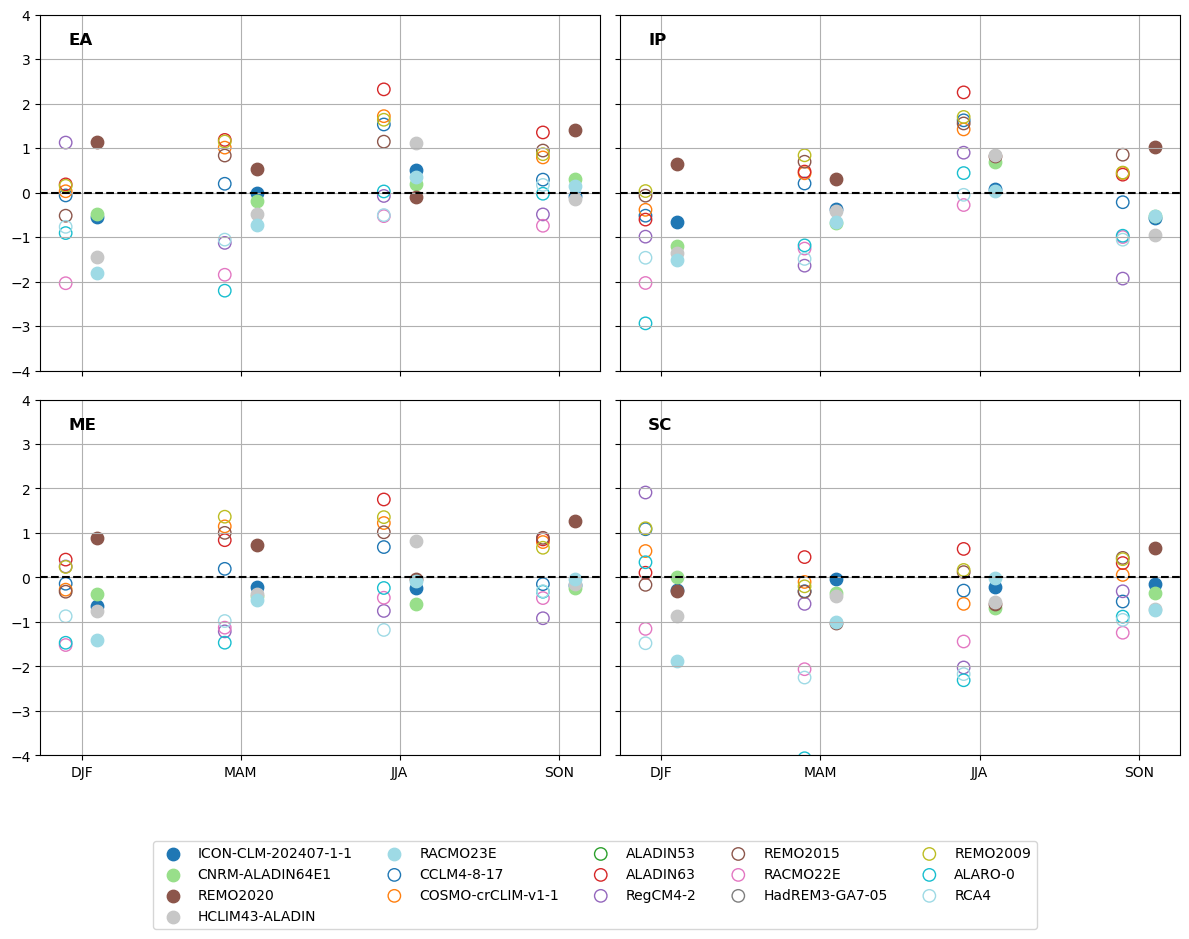

In [110]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

df_CMIP6 = dset_id_regions_CMIP6.to_dataframe().reset_index()
df_CMIP5 = dset_id_regions_CMIP5.to_dataframe().reset_index()

seasons = ["DJF", "MAM", "JJA", "SON"]
regions = ["EA", "IP", "ME", "SC"]

unique_dsets_CMIP6 = df_CMIP6['dset_id'].unique()
cmap_CMIP6 = cm.get_cmap('tab20', len(unique_dsets_CMIP6))

unique_dsets_CMIP5 = df_CMIP5['dset_id'].unique()
cmap_CMIP5 = cm.get_cmap('tab20', len(unique_dsets_CMIP5))

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regions):
    ax = axes[i]
    
    df_CMIP6_region = df_CMIP6[df_CMIP6["abbrevs"] == region]
    df_CMIP5_region = df_CMIP5[df_CMIP5["abbrevs"] == region]
    
    df_CMIP6_region['season_num'] = df_CMIP6_region['season'].apply(lambda x: seasons.index(x))
    df_CMIP5_region['season_num'] = df_CMIP5_region['season'].apply(lambda x: seasons.index(x))
    
    df_CMIP6_region['season_shifted'] = df_CMIP6_region['season_num'] + 0.1
    df_CMIP5_region['season_shifted'] = df_CMIP5_region['season_num'] - 0.1
    
    for idx, row in df_CMIP6_region.iterrows():
        dset_id = row['dset_id']
        color = cmap_CMIP6(np.where(unique_dsets_CMIP6 == dset_id)[0][0])
        scatter = ax.scatter(row['season_shifted'], row[variable], color=color, edgecolors=color, marker='o', s=80)
        
        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)
    
    for idx, row in df_CMIP5_region.iterrows():
        dset_id = row['dset_id']
        color = cmap_CMIP5(np.where(unique_dsets_CMIP5 == dset_id)[0][0])
        scatter = ax.scatter(row['season_shifted'], row[variable], color=color, edgecolors=color, facecolor='none', marker='o', s=80)
        
        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    # Add region label in the top-left corner of each subplot
    ax.text(0.05, 0.95, region, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='black', weight='bold')

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=10)

plt.ylim([-4, 4])
plt.tight_layout()
plt.show()
fig.savefig(f"{mip_era}_region_bias_{variable}_{period.start}-{period.stop}.pdf", bbox_inches='tight', transparent=True, pad_inches=0)